# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [1]:
import torch
import torchvision

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Torch version: 2.1.2
Torchvision version: 0.16.2


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 46.91 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
image_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78439fbd86d0>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapesimage.shape, label

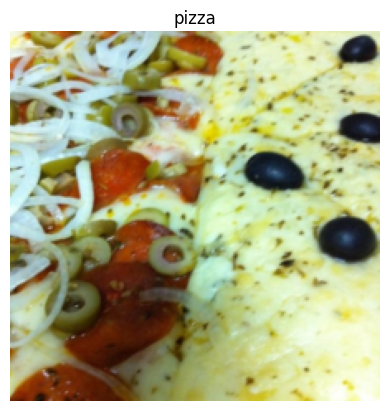

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

### Train two models on Pizza, Steak, Sushi data

Need:
* Trained EffNetB2 feature extractor
* Trained ViT feature extractor

### EffnetB2

In [10]:
def create_effnetb2_model(num_classes:int=3,
                         seed:int=42):
    """Creates an EfficienetNetB2 feature extractor model and transforms"""
    
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)
    
    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad=False
        
    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )
    
    return model, transforms

In [11]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                     seed=42)
effnetb2_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 59.6MB/s]


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [13]:
# Create dataloader for EffNetB2
from going_modular.going_modular import data_setup

BATCH_SIZE = 32

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                test_dir=test_dir,
                                                                                                transform=effnetb2_transforms,
                                                                                                batch_size=BATCH_SIZE)

In [14]:
print(f"Length of train dataloader: {len(train_dataloader_effnetb2)}")
print(f"Length of test dataloader: {len(test_dataloader_effnetb2)}")
print(f"Class names: {class_names}")

Length of train dataloader: 15
Length of test dataloader: 5
Class names: ['pizza', 'steak', 'sushi']


In [15]:
# Train EffNetB2 feature extractor
from going_modular.going_modular import engine

LEARNING_RATE = 1e-3
EPOCHS = 10

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=LEARNING_RATE)

# Setup loss
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=EPOCHS,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5667 | test_loss: 0.7411 | test_acc: 0.9347
Epoch: 2 | train_loss: 0.7172 | train_acc: 0.8396 | test_loss: 0.5878 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5879 | train_acc: 0.8938 | test_loss: 0.4901 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4481 | train_acc: 0.9125 | test_loss: 0.4349 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4302 | train_acc: 0.9062 | test_loss: 0.3921 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4400 | train_acc: 0.8875 | test_loss: 0.3523 | test_acc: 0.9597
Epoch: 7 | train_loss: 0.4253 | train_acc: 0.8792 | test_loss: 0.3267 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3900 | train_acc: 0.8979 | test_loss: 0.3462 | test_acc: 0.9352
Epoch: 9 | train_loss: 0.3770 | train_acc: 0.8771 | test_loss: 0.3130 | test_acc: 0.9131
Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8625 | test_loss: 0.2814 | test_acc: 0.9688


    With label_smoothing=0.1
    Epoch: 1 | train_loss: 0.9995 | train_acc: 0.5750 | test_loss: 0.7876 | test_acc: 0.9347
    Epoch: 2 | train_loss: 0.7701 | train_acc: 0.8396 | test_loss: 0.6612 | test_acc: 0.9409
    Epoch: 3 | train_loss: 0.6681 | train_acc: 0.8938 | test_loss: 0.5878 | test_acc: 0.9563
    Epoch: 4 | train_loss: 0.5613 | train_acc: 0.9146 | test_loss: 0.5519 | test_acc: 0.9409
    Epoch: 5 | train_loss: 0.5538 | train_acc: 0.9125 | test_loss: 0.5246 | test_acc: 0.9352
    Epoch: 6 | train_loss: 0.5736 | train_acc: 0.8875 | test_loss: 0.4982 | test_acc: 0.9597
    Epoch: 7 | train_loss: 0.5615 | train_acc: 0.8833 | test_loss: 0.4864 | test_acc: 0.9563
    Epoch: 8 | train_loss: 0.5459 | train_acc: 0.8958 | test_loss: 0.5055 | test_acc: 0.9381
    Epoch: 9 | train_loss: 0.5355 | train_acc: 0.8896 | test_loss: 0.4813 | test_acc: 0.9193
    Epoch: 10 | train_loss: 0.5427 | train_acc: 0.8562 | test_loss: 0.4656 | test_acc: 0.9688
    
    Without label_smoothing=0.1
    Epoch: 1 | train_loss: 0.9844 | train_acc: 0.5667 | test_loss: 0.7411 | test_acc: 0.9347
    Epoch: 2 | train_loss: 0.7172 | train_acc: 0.8396 | test_loss: 0.5878 | test_acc: 0.9409
    Epoch: 3 | train_loss: 0.5879 | train_acc: 0.8938 | test_loss: 0.4901 | test_acc: 0.9563
    Epoch: 4 | train_loss: 0.4481 | train_acc: 0.9125 | test_loss: 0.4349 | test_acc: 0.9409
    Epoch: 5 | train_loss: 0.4302 | train_acc: 0.9062 | test_loss: 0.3921 | test_acc: 0.9443
    Epoch: 6 | train_loss: 0.4400 | train_acc: 0.8875 | test_loss: 0.3523 | test_acc: 0.9597
    Epoch: 7 | train_loss: 0.4253 | train_acc: 0.8792 | test_loss: 0.3267 | test_acc: 0.9563
    Epoch: 8 | train_loss: 0.3900 | train_acc: 0.8979 | test_loss: 0.3462 | test_acc: 0.9352
    Epoch: 9 | train_loss: 0.3770 | train_acc: 0.8771 | test_loss: 0.3130 | test_acc: 0.9131
    Epoch: 10 | train_loss: 0.3769 | train_acc: 0.8625 | test_loss: 0.2814 | test_acc: 0.9688


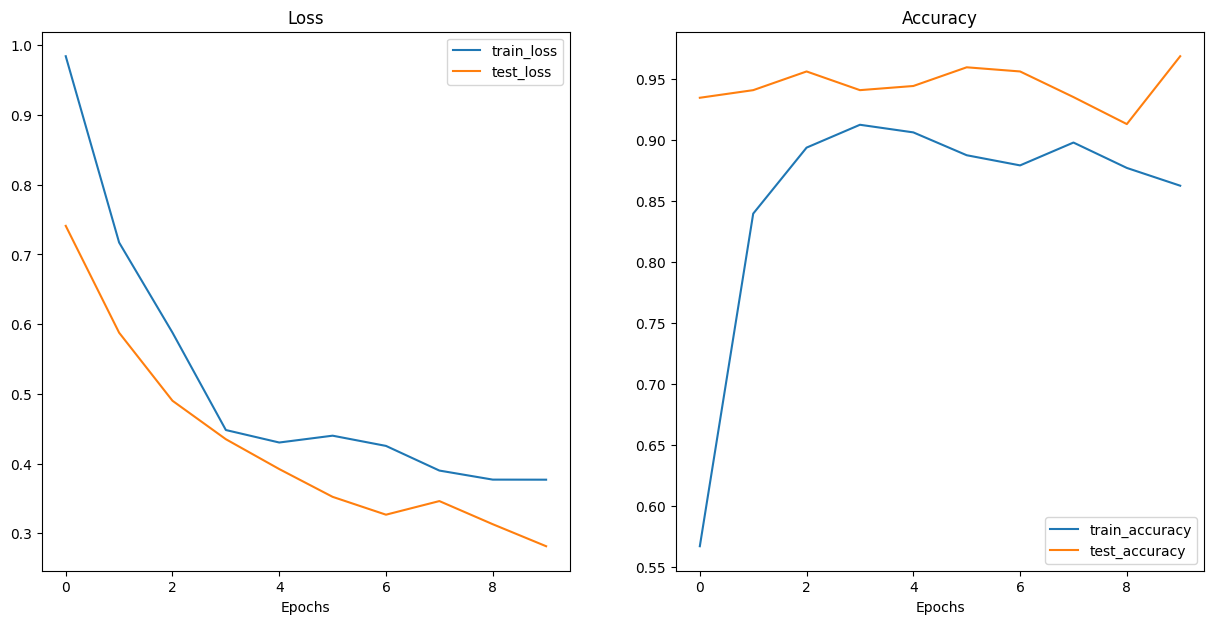

In [16]:
plot_loss_curves(effnetb2_results)

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [17]:
def create_vit_model(num_classes:int=3,
                    seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms."""
    
    # Create ViT_B_16 pretrainet weights, transform and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)
    
    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False
        
    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))
    
    return model, transforms

In [18]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 76.4MB/s] 


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [19]:
# Create dataloaders for ViT
from going_modular.going_modular import data_setup

BATCH_SIZE = 32

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                              test_dir=test_dir,
                                                                              transform=vit_transforms,
                                                                              batch_size=BATCH_SIZE)

print(f"Lenght of train dataloader: {len(train_dataloader_vit)}") 
print(f"Length of test dataloader: {len(test_dataloader_vit)}")
print(f"Class names: {class_names}")

Lenght of train dataloader: 15
Length of test dataloader: 5
Class names: ['pizza', 'steak', 'sushi']


In [20]:
# Train ViT feature extractor
from going_modular.going_modular import engine

LEARNING_RATE = 1e-3
EPOCHS = 10

optimizer = torch.optim.Adam(params=vit.parameters(), lr=LEARNING_RATE)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                            test_dataloader=test_dataloader_vit,
                            train_dataloader=train_dataloader_vit,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


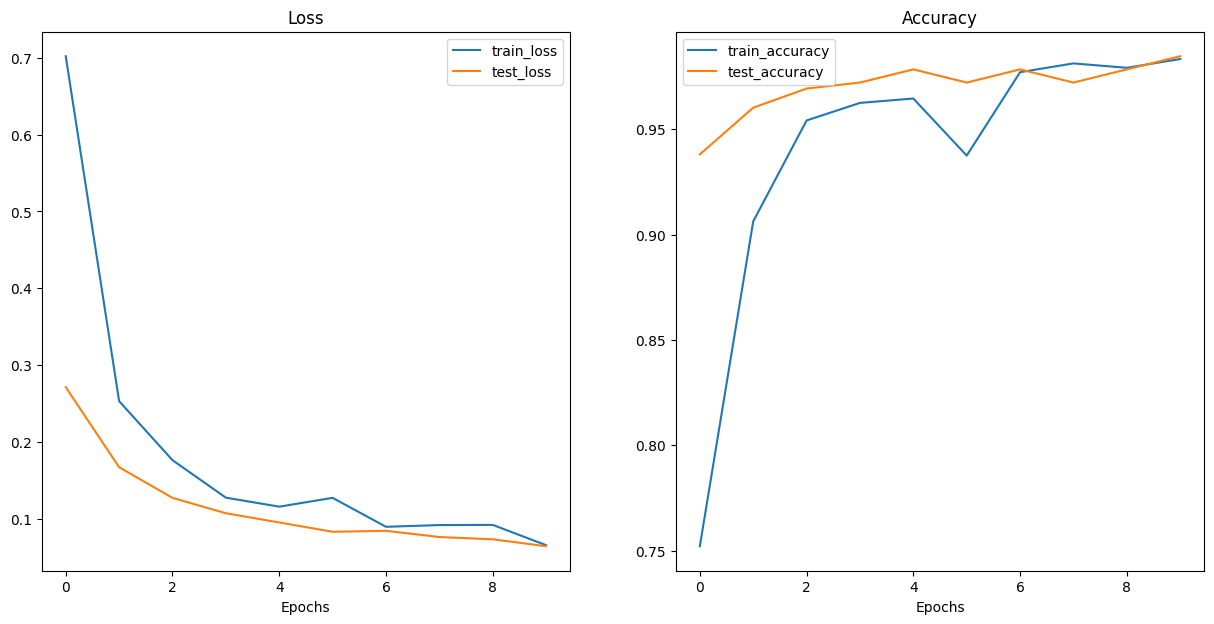

In [21]:
plot_loss_curves(vit_results)

# Get all the images from test path

Want to make predictions across the test dataset images and time them on GPU to see if they're faster on GPU or CPU

In [22]:
from pathlib import Path

test_image_paths = list(Path(test_dir).glob("*/*.jpg"))

print(f"Number of test images: {len(test_image_paths)}")

Number of test images: 150


In [23]:
test_image_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/911808.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/57230.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/3834718.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/705150.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/sushi/593071.jpg')]

# Get function for making predictions and timing them

In [24]:
!nvidia-smi

Sun Feb 18 17:52:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0              43W / 250W |   1126MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [25]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths:List[pathlib.Path],
                  model:torch.nn.Module,
                  transform:torchvision.transforms,
                  class_names: List[str],
                  device: str="cuda" if torch.cuda.is_available() else "cpu"):
    
    # Create an empty list to store prediction dictionaries
    pred_list = []
    
    # Loop through target paths
    for path in tqdm(paths):
        
        # Create empty dictionary to store prediction information for each sample
        pred_dict = {}
        
        # Get the sample path and ground trught class names
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # start timer
        start_time = timer()
        
        # open image path
        img = Image.open(path)
        
        # transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)
        
        # prepare model for inference by sendint to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # get prediction probability, prediction label and prediction class
        with torch.inference_mode():
            pred_logit=model(transformed_image)
            pred_prob=torch.softmax(pred_logit, dim=1)
            pred_label=torch.argmax(pred_prob,dim=1)
            pred_class=class_names[pred_label.cpu()]
            
            # Make sure things in the directory are on CPU
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().item(),4)
            pred_dict["pred_class"] = pred_class
            
            # end the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)
            
        # Does the pred match the tru label?
        pred_dict["correct"] = class_name == pred_class
        
        # Add the dictionary to the list of preds
        pred_list.append(pred_dict)
        
    # return list of prediction dictionaries
    return pred_list

# Preciction on CPU

In [26]:
# Make prediction times on CPU
start_time = timer()
effnetb2_preds_on_cpu = pred_and_store(paths=test_image_paths,
                                      model=effnetb2,
                                      transform=effnetb2_transforms,
                                      class_names=class_names,
                                      device="cpu")
end_time = timer()
print(f"Total EfficientNetB2 prediction time on CPU: {round(end_time - start_time,2)}sec")

  0%|          | 0/150 [00:00<?, ?it/s]

Total EfficientNetB2 prediction time on CPU: 15.97sec


In [27]:
# Make prediction times on gpu
start_time = timer()
vit_preds_on_cpu = pred_and_store(paths=test_image_paths,
                                      model=vit,
                                      transform=vit_transforms,
                                      class_names=class_names,
                                      device="cpu")
end_time = timer()
print(f"Total ViT prediction time on CPU: {round(end_time - start_time,2)}sec")

  0%|          | 0/150 [00:00<?, ?it/s]

Total ViT prediction time on CPU: 56.06sec


# Prediction on GPU

In [28]:
# Make prediction times on CPU
start_time = timer()
effnetb2_preds_on_gpu = pred_and_store(paths=test_image_paths,
                                      model=effnetb2,
                                      transform=effnetb2_transforms,
                                      class_names=class_names,
                                      device="cuda")
end_time = timer()
print(f"Total EfficientNetB2 prediction time on GPU: {round(end_time - start_time,2)}sec")

  0%|          | 0/150 [00:00<?, ?it/s]

Total EfficientNetB2 prediction time on GPU: 4.12sec


In [29]:
# Make prediction times on gpu
start_time = timer()
vit_preds_on_gpu = pred_and_store(paths=test_image_paths,
                                      model=vit,
                                      transform=vit_transforms,
                                      class_names=class_names,
                                      device="cuda")
end_time = timer()
print(f"Total ViT prediction time on GPU: {round(end_time - start_time,2)}sec")

  0%|          | 0/150 [00:00<?, ?it/s]

Total ViT prediction time on GPU: 2.86sec


### Comparing prediction times on CPU and GPU

In [30]:
import pandas as pd

def get_mean_time(input):
    df = pd.DataFrame(input)
    return df.time_for_pred.mean()

In [31]:
effnetb2_cpu_pred_time = get_mean_time(effnetb2_preds_on_cpu)
vit_cpu_pred_time = get_mean_time(vit_preds_on_cpu)
effnetb2_gpu_pred_time = get_mean_time(effnetb2_preds_on_gpu)
vit_gpu_pred_time = get_mean_time(vit_preds_on_gpu)

pred_times = {"effnet_cpu" :effnetb2_cpu_pred_time,
             "effnet_gpu":effnetb2_gpu_pred_time,
             "vit_cpu":vit_cpu_pred_time,
             "vit_gpu":vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

,effnet_cpu,effnet_gpu,vit_cpu,vit_gpu
0,0.105553,0.027193,0.372722,0.018832


# Exercise 2. ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2

In [32]:
from torchinfo import summary

# Create another ViT feature model instance
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

summary(model=vit_food101_20_percent,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [33]:
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [34]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir,
                             split="train",
                             transform=food101_train_transforms,
                             download=True)

# Get testing data (~250 images x 10 food classes)
test_data = datasets.Food101(root=data_dir,
                            split="test",
                            transform=vit_transforms,
                            download=True)

100%|██████████| 4996278331/4996278331 [03:05<00:00, 26966997.96it/s]


Extracting data/food-101.tar.gz to data


In [35]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [36]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions"""
    
    # Create split lenghts baset on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = int(len(dataset) - length_1)
    
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                  lengths=[length_1, length_2],
                                                                  generator=torch.manual_seed(seed))
    
    return random_split_1, random_split_2

In [37]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                               split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                               split_size=0.2)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


In [38]:
print(f"Length of train data: {len(train_data_food101_20_percent)}")
print(f"Length of test data: {len(test_data_food101_20_percent)}")

Length of train data: 15150
Length of test data: 5050


In [39]:
# Turn torch Dataset into DataLoaders
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_food101 = DataLoader(train_data_food101_20_percent,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

test_dataloader_food101 = DataLoader(test_data_food101_20_percent,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [40]:
print(f"Length of train dataloader: {len(train_dataloader_food101)}")
print(f"Length of test dataloader: {len(test_dataloader_food101)}")

Length of train dataloader: 474
Length of test dataloader: 158


# Train ViT feature extractor on 20% of Food101 data

In [41]:
LEARNING_RATE = 1e-3
EPOCHS = 5

# Loss function 
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# optimizer
optimizer = torch.optim.Adam(vit_food101_20_percent.parameters(),
                            lr=LEARNING_RATE)

# Train the model
start_time = timer()
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                                            train_dataloader=train_dataloader_food101,
                                            test_dataloader=test_dataloader_food101,
                                            epochs=EPOCHS,
                                            loss_fn=loss_fn,
                                            optimizer=optimizer,
                                            device=device)
end_time = timer()
print(f"Total training time ViT - food101 20% of data {EPOCHS} epochs {end_time - start_time}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8456 | train_acc: 0.4291 | test_loss: 2.0698 | test_acc: 0.6243
Epoch: 2 | train_loss: 2.2201 | train_acc: 0.5920 | test_loss: 1.9248 | test_acc: 0.6668
Epoch: 3 | train_loss: 2.0698 | train_acc: 0.6429 | test_loss: 1.8728 | test_acc: 0.6925
Epoch: 4 | train_loss: 1.9516 | train_acc: 0.6781 | test_loss: 1.8458 | test_acc: 0.7029
Epoch: 5 | train_loss: 1.8917 | train_acc: 0.7011 | test_loss: 1.8345 | test_acc: 0.6992
Total training time ViT - food101 20% of data 5 epochs 697.9069710650001


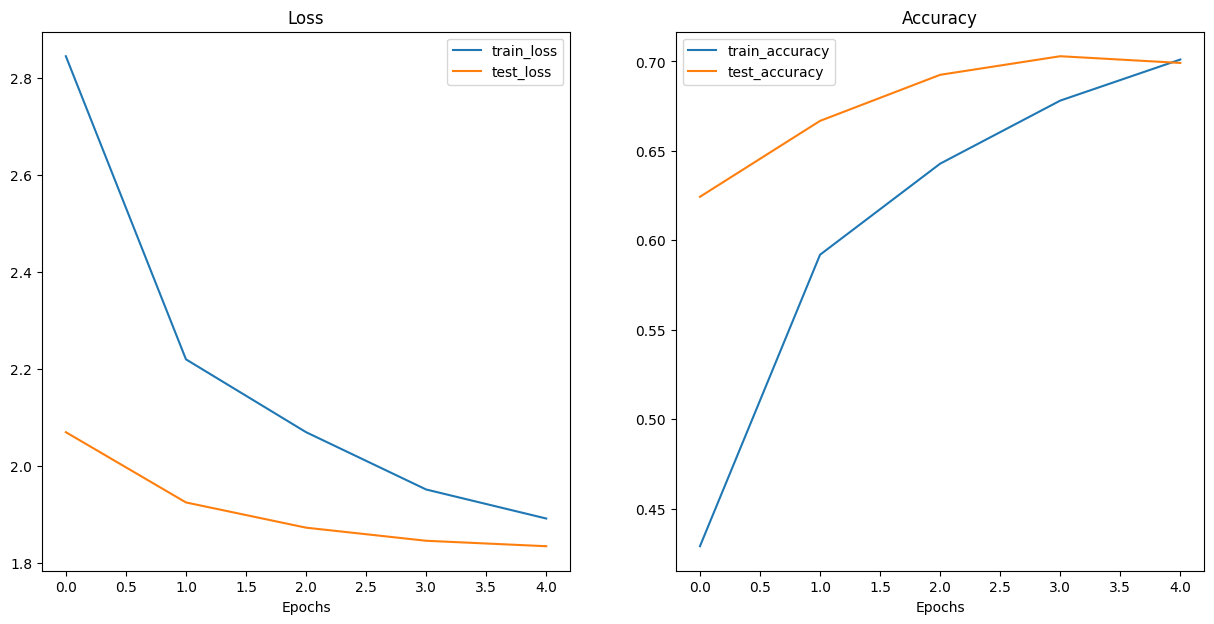

In [42]:
plot_loss_curves(vit_food101_20_percent_results)

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [43]:
import os

NUM_WORKERS = os.cpu_count()

# Loop through test DataLoader
# Make prediction with model
# Store prediction and prediction probability in dictionary
# Append dictionary to list

# Crate batch size of 1 (predictt on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                                                 batch_size=1,
                                                 shuffle=False,
                                                 num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader witch batch size 1 and make prediction on each picture
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
    X, y = X.to(device), y.to(device)
    
    # Create empty dictionary
    pred_dict = {}
    
    # Make predictions
    with torch.inference_mode():
        pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)
        pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
        pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
        pred_dict["label"] = y.cpu().numpy()[0]
        
    vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [44]:
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]
pred_df_20_percent.head()

,pred_prob,pred_label,label,is_correct
0,0.8562116,72,72,True
1,0.594775,57,57,True
2,0.13073976,80,80,True
3,0.78438187,51,51,True
4,0.8446122,1,1,True


In [45]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction.
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)

,pred_prob,pred_label,label,is_correct
3107,0.9727108,52,32,False
1306,0.96145815,71,44,False
3436,0.9491215,45,58,False
1726,0.9361476,68,43,False
1872,0.93424416,79,37,False
...,...,...,...,...
362,0.07940003,28,21,False
4265,0.07791688,15,11,False
3926,0.071728416,8,42,False
1669,0.07078263,52,78,False


In [46]:
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])

pred_df_20_percent.head()

,pred_prob,pred_label,label,is_correct,pred_class,label_class
0,0.8562116,72,72,True,pancakes,pancakes
1,0.594775,57,57,True,hummus,hummus
2,0.13073976,80,80,True,pulled_pork_sandwich,pulled_pork_sandwich
3,0.78438187,51,51,True,guacamole,guacamole
4,0.8446122,1,1,True,baby_back_ribs,baby_back_ribs


In [47]:
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

,pred_prob,pred_label,label,is_correct,pred_class,label_class
3107,0.9727108,52,32,False,gyoza,dumplings
1306,0.96145815,71,44,False,paella,fried_rice
3436,0.9491215,45,58,False,frozen_yogurt,ice_cream
1726,0.9361476,68,43,False,onion_rings,fried_calamari
1872,0.93424416,79,37,False,prime_rib,filet_mignon
2848,0.9132217,41,8,False,french_onion_soup,bread_pudding
333,0.87191635,87,89,False,scallops,shrimp_and_grits
2287,0.8699076,38,28,False,fish_and_chips,croque_madame
4995,0.8636432,26,71,False,crab_cakes,paella
1454,0.86209166,79,37,False,prime_rib,filet_mignon


In [48]:
pred_df_20_percent.is_correct.value_counts()

is_correct
True     3531
False    1519
Name: count, dtype: int64

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [49]:
# Check length of Food101 test data
len(test_data)

25250

In [50]:
# Turn Food101 test data into DataLoader
test_dataloader_food_101_all_data_batch_size_1 = DataLoader(test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

print(f"Length of data to test: {len(test_dataloader_food_101_all_data_batch_size_1)}")

# start timer
start_time = timer()

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader witch batch size 1 and make prediction on each picture
vit_food101_all_test_data_pred_list = []

for X, y in tqdm(test_dataloader_food_101_all_data_batch_size_1):
    X, y = X.to(device), y.to(device)
    
    # Create empty dictionary
    pred_dict = {}
    
    # Make predictions
    with torch.inference_mode():
        pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
        pred_labels = torch.argmax(pred_probs, dim=1)
        pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
        pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
        pred_dict["label"] = y.cpu().numpy()[0]
        
    vit_food101_all_test_data_pred_list.append(pred_dict)
    
stop_time = timer()
print(f"Total time of predictions across whole data set: {stop_time - start_time}")

Length of data to test: 25250


  0%|          | 0/25250 [00:00<?, ?it/s]

Total time of predictions across whole data set: 303.34559274699996


In [51]:
# Evaluate model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

is_correct
True     17773
False     7477
Name: count, dtype: int64

In [52]:
# Calcualte accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[0] / len(food101_all_test_data_df)}")

Accuracy of ViT model on all of Food101 test data: 0.7038811881188118


/tmp/ipykernel_34/3077115709.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[0] / len(food101_all_test_data_df)}")


## Exercise 5. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?


Problems:
1. **Someone uploads a photo that isn't food...**
    * Potential solution: train two models, one that classifiers images into "food" or "not food" and if an image is found to be "food", classify it into a certain class.
2. **Someone uploads a photo but our model doesn't have the capacity to classify that certain class...**
    * Potential solution: 
        * Get more data for unknown classes (upgrade the model).
        * Ask someone if the prediction is right/wrong, if it's wrong, track it to a database and update later (active learning).
3. **The image quality is poor (food in other place than center)**
    * Potential solution: add guidelines to the camera app to hint at taking a photo
4. **Multiple foods in one shot**
    * Potential solutions:
        * Return multiple classification results (e.g. the top 5 classification prediction probabilities)
        * Object detection (detect each different food in an image and individually classify them)

## Exercise 6. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

# Save model

In [53]:
from going_modular.going_modular import utils

# Create a model path
vit_all_data_model_path = "pretrained_vit_model_from_exercise.pth"

# Save Exercise model
utils.save_model(model=vit_food101_20_percent,
                 target_dir="models",
                 model_name=vit_all_data_model_path)

[INFO] Saving model to: models/pretrained_vit_model_from_exercise.pth


# Check model size

In [54]:
# Check model size
from pathlib import Path

pretrained_vit_food101_model_size = Path("models", vit_all_data_model_path).stat().st_size // (1024*1024)
print(f"Pretrained vit food101 model size: {pretrained_vit_food101_model_size} MB")

Pretrained vit food101 model size: 327 MB


# Create directories

In [55]:
# creating demo directory
from pathlib import Path

# Create demo path
foodvision_exercise_demo_path = Path("demos/foodvision_exercise")

# Make demo directory
foodvision_exercise_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Exercise example directory
(foodvision_exercise_demo_path / "examples").mkdir(parents=True, exist_ok=True)

# Download samples and move

In [1]:
# Download and move example images
!wget https://raw.githubusercontent.com/DarekW90/photo_sample/main/pizza.jpg
!mv pizza.jpg demos/foodvision_exercise/examples/pizza.jpg

!wget https://raw.githubusercontent.com/DarekW90/photo_sample/main/steak.jpg
!mv steak.jpg demos/foodvision_exercise/examples/steak.jpg

!wget https://raw.githubusercontent.com/DarekW90/photo_sample/main/sushi.jpg
!mv sushi.jpg demos/foodvision_exercise/examples/sushi.jpg

--2024-02-18 19:39:05--  https://raw.githubusercontent.com/DarekW90/photo_sample/main/pizza.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80262 (78K) [image/jpeg]
Saving to: 'pizza.jpg'

pizza.jpg           100%[===================>]  78.38K  --.-KB/s    in 0.02s   

2024-02-18 19:39:05 (5.02 MB/s) - 'pizza.jpg' saved [80262/80262]

mv: cannot move 'pizza.jpg' to 'demos/foodvision_exercise/examples/pizza.jpg': No such file or directory
--2024-02-18 19:39:07--  https://raw.githubusercontent.com/DarekW90/photo_sample/main/steak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
H

# Move model

In [57]:
# Move model
!mv models/pretrained_vit_model_from_exercise.pth demos/foodvision_exercise/

# Create txt file with all 101 class names

In [62]:
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [63]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_exercise_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos/foodvision_exercise/class_names.txt


In [64]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded=[food.strip() for food in f.readlines()]
    
# view the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

# Write model.app

In [65]:
import torch
import torchvision

from torch import nn

def create_vit_model(num_classes:int=3,
                    seed:int=42):
    """Creates an feature extractor model and transforms"""
    # Create weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)
    
    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False
        
    # change classifier head to suit needs
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768,
                                         out_features=num_classes))
    
    return model, transforms

Writing demos/foodvision_exercise/model.py


# Write app.py

In [66]:
%%writefile demos/foodvision_exercise/app.py
#### Imports and class names setup ####
import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

#### Model an transforms preparation ####

# Create ViT model
vit_food101, vit_food101_transforms = vit_food101_20_percent(num_classes=3)

# Load saved weights
vit_food101.load_state_dict(
    torch.load (f="pretrained_vit_model_from_exercise.pth", map_location=torch.device("cpu")))

#### Predict function ####

def predict(img) -> Tuple[Dict. float]:
    """Transforms and performs a prediction on image and returns predictions"""
    # Start timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = vit_food101_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    vit_food101.eval()
    with torch.inference_mode():
        # pass the transformed image through the model and turn the prediction logits and prediction probabilities
        pred_probs = torch.softmax(vit_food101(img), dim=1)
        
    # Create a prediction label and prediction probability dictionary for each prediction
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate prediction time
    pred_time = round(timer() - start_time,5)
    
    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

#### Gradio App ####

# Create title, description and article strings
title = "FoodVision Exercise👨‍🏫"
description = "A model finished step by step only with documentation from course"
article = "18/02/24 DW"

# Create examples list from `examples/` directory
example_list = [["example/" + example] for example in os.listdir("examples")]

# Create the Gradio Demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                    gr.Number(label="Prediction time(s)")],
                    # Create examples list from "example/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch()

Writing demos/foodvision_exercise/app.py


# Download Gradio app

In [67]:
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr
    
gr.__version__

'4.19.1'

# Write file requiremets.txt

In [68]:
import torch
import torchvision
import gradio as gr

print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Gradio version: {gr.__version__}")

Torch version: 2.1.2
Torchvision version: 0.16.2
Gradio version: 4.19.1


In [69]:
%%writefile demos/foodvision_exercise/requirements.txt
torch==2.1.2
torchvision==0.16.2
gradio==4.19.1

Writing demos/foodvision_exercise/requirements.txt


# Zip files

In [70]:
!cd demos/foodvision_exercise && zip -r ../foodvision_exercise.zip * -x "*pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 57%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/sushi.jpg (deflated 57%)
  adding: examples/steak.jpg (deflated 57%)
  adding: examples/pizza.jpg (deflated 57%)
  adding: model.py (deflated 53%)
  adding: pretrained_vit_model_from_exercise.pth (deflated 7%)
  adding: requirements.txt (deflated 4%)
